In [21]:
#import agentpy as ap
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from tqdm import tqdm
from datetime import datetime
import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.bokeh.MultiPlot import MultiPlot
from ndlib.viz.bokeh.DiffusionPrevalence import DiffusionPrevalence
from bokeh.io import output_notebook, show
from pprint import pprint
#import json, re, demjson
import sys
import random
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
%matplotlib inline

# Stationary opinion 

In [109]:
parameters = {
    'population': 900,
    'steps': 350000,
    'num_partners': 1,
    'mu': 0.5,
    'd':0.9,
    'number_of_neighbors': 2,
    'min_percen': 5,
    'cascade_ct': 2}





#graph = nx.barabasi_albert_graph(parameters['population'], parameters['number_of_neighbors'])

1478 1478


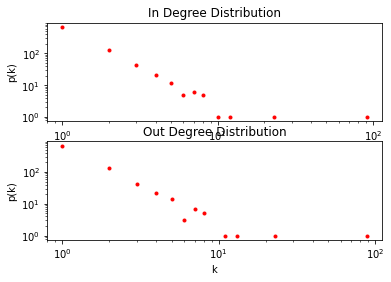

In [91]:
"""CREAMOS EL EDGELIST DEL GRAPH"""

def plot_degree_dist(G):
    in_degrees = G.in_degree()
    in_degrees=dict(in_degrees)
    in_values = sorted(set(in_degrees.values()))
    in_hist = [list(in_degrees.values()).count(x) for x in in_values]

    plt.subplot(2,1,1) 
    plt.grid(False)
    plt.loglog(in_values, in_hist, 'r.') 
    plt.xlabel('k')
    plt.ylabel('p(k)')
    plt.title('In Degree Distribution')

    out_degrees = G.out_degree()
    out_degrees=dict(out_degrees)
    out_values = sorted(set(out_degrees.values()))
    out_hist = [list(out_degrees.values()).count(x) for x in out_values]

    plt.subplot(2,1,2)
    plt.grid(False)
    plt.loglog(out_values, out_hist, 'r.') 
    plt.xlabel('k')
    plt.ylabel('p(k)')
    plt.title('Out Degree Distribution')
    plt.show()


while True:  
    s=[]
    while len(s)<parameters['population']:
        nextval = int(nx.utils.powerlaw_sequence(1, 3)[0]) #100 nodes, power-law exponent 2.5

        if nextval!=0:
            s.append(nextval)

    if sum(s)%2 == 0:
        break

din = s


#print(sum(din),sum(dout))
dout=random.sample(s,len(s))
#dout = z1

print(sum(din),sum(dout))

graph = nx.directed_configuration_model(din, dout)
graph=nx.DiGraph(graph) # remove parallel edges
graph.remove_edges_from(nx.selfloop_edges(graph))
plot_degree_dist(graph)
G=graph.to_undirected(reciprocal=False, as_view=False)


In [110]:
#creamos una opinion uniformemente distribuida

"""DISTRIBUIMOS UNA OPINION ALEATORIA A LOS NODOS"""

opinion=[]
    
for x in range(len(G.nodes)):
    opinion.append(random.uniform(0,1))
ini_opinion=opinion.copy()    

opinions=[]
opinions.append(opinion.copy())#esta lista de listas sólo la necesito si quiero guardar todo el historial

In [111]:
degrees = [val for (node, val) in G.degree()]
print('connectivity of the network  '+str(np.mean(degrees)))

connectivity of the network  3.2377777777777776


In [112]:
for x in range(parameters['steps']):
    #print(x)
    """seleccionamos un nodo y un vecino de ese nodo aleatoriamente"""
    
    nodo = random.choice(list(G.nodes))#nodo al azar accediendo directamente a la lista de nodos

    vecino = random.choice(list(G.neighbors(nodo)))#vecino al azar accediendo directamente a la lista de vecinos del nodo    

    """definicion de la interacion entre nodos"""
    
    opinion_diff = opinion[nodo] - opinion[vecino] #la opinion del nodo n estará en la posicion n de la lista
   
    if abs(opinion_diff) <= parameters['d']:
        opinion_change = parameters['mu'] * opinion_diff
        opinion[nodo]=opinion[nodo]-opinion_change

   
    opinions.append(opinion.copy())#aquí me guardo la lista de opinion a cada paso por si quiero graficar toda la dínamica, si no lo quiero no necesito esta copia

In [113]:
nodo=random.choice(list(G.nodes))#nodo al azar accediendo directamente a la lista de nodos

vecino=random.choice(list(G.neighbors(nodo)))#vecino al azar accediendo directamente a la lista de vecinos del nodo   
print(nodo,vecino)

832 641


In [ ]:
"""creamos la variable tiempo"""
cada=1000
tiempo = []
opinions1=[]
for i in range(parameters['steps']):
    tiempo.append([])
    for j in range(parameters['population']):

        tiempo[i].append(i)

tiempo = [elemento  for elemento in tiempo if elemento[1]%cada==0]
        
for x in range(parameters['steps']):
    if x%cada==0:
        opinions1.append(opinions[x])


In [60]:
"""for i in range(0,parameters['steps'],cada):
    tiempo.append([])

    for j in range(parameters['population']):

        tiempo[i].append(i)"""

"for i in range(0,parameters['steps'],cada):\n    tiempo.append([])\n\n    for j in range(parameters['population']):\n\n        tiempo[i].append(i)"

(0.0, 1.0)

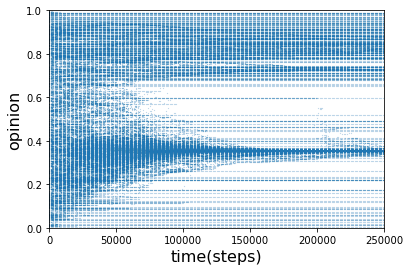

In [61]:
#%matplotlib inline
plt.scatter(tiempo, opinions1, s=0.01)
plt.ylabel("opinion", size = 16)
plt.xlabel("time(steps)", size = 16)
plt.xlim(0,parameters['steps'])
plt.ylim(0,1)  

(0.0, 1.0)

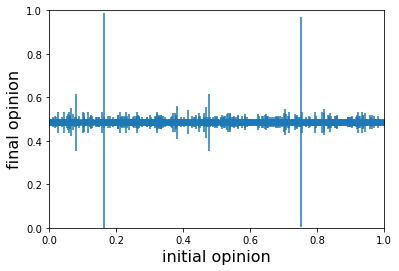

In [114]:
#plt.scatter(opinions[0],opinions[-1], s=1)
plt.errorbar(opinions[0],opinions[-1],yerr=[d/(2*float(max(degrees))) for d in degrees],fmt="o",markersize=5)

#finalopinion vs initial opinion 
plt.ylabel("final opinion", size = 16)
plt.xlabel("initial opinion", size = 16)
plt.xlim(0,1)
plt.ylim(0,1)  

In [32]:
#%reset


# information diffusion 

In [123]:
def compute_independent_cascade(graph, prob, n_iters=200000):
    total_spead = 0
    seeds_offs=[]
    nodes_offs=[]
    cascade_size=[]
    # simulate the spread process over multiple runs
    for i in range(n_iters):
        seed_nodes = [np.random.choice(graph.nodes)]

        np.random.seed(i)
        active = seed_nodes[:]
        new_active = seed_nodes[:]
        
        # for each newly activated nodes, find its neighbors that becomes activated
        
        num=0#contador para separar las seeds offspring y node offspring
        while new_active:
            
            num=num+1
            
            activated_nodes = []
            
            for node in new_active:
                neighbors = list(graph.neighbors(node))
                success = np.random.uniform(0, 1, len(neighbors)) < prob*(1-abs(opinion[node]-opinion[seed_nodes[0]]))
                activated_nodes += list(np.extract(success, neighbors))
                if node in seed_nodes:
                    seeds_offs.append(len(list(np.extract(success,neighbors))))
                else:
                    nodes_offs.append(len(list(np.extract(success,neighbors))))
            #if num == 1:
                #seeds_offs.append(len(activated_nodes))
            #else:
                #nodes_offs.append(len(activated_nodes)/len(new_active))
            # ensure the newly activated nodes doesn't already exist
            # in the final list of activated nodes before adding them
            # to the final list
            new_active = list(set(activated_nodes) - set(active))
            active += new_active

        total_spead += len(active)
        #print(total_spead)
               
        cascade_size.append(len(active))
    fig = plt.figure("seed offspring and node offspring", figsize=(8, 8))
    # Create a gridspec for adding subplots of different sizes
    axgrid = fig.add_gridspec(7, 7)


    #n_bins1=len(seeds_offs)
    counts, bins = np.histogram(seeds_offs)
    #plt.hist(bins[:-1], bins, weights=counts)
    #print(n_bins1)
    ax0 = fig.add_subplot(axgrid[:3, :3])
    ax0.hist(bins[:-1], bins, weights=counts,density=True )
    ax0.set_title(" seeds_offs")
    #ax1.set_xscale('log')
    ax0.set_yscale('log')
    ax0.set_ylabel("counts")
    ax0.set_xlabel("offspring")


    #n_bins2=len(nodes_offs)
    counts1, bins1 = np.histogram(nodes_offs)
    #plt.hist(bins[:-1], bins, weights=counts)

    ax1 = fig.add_subplot(axgrid[:3, 4:])
    ax1.hist(bins[:-1], bins, weights=counts1,density=True)
    ax1.set_title("nodes_offs")
    #ax3.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_ylabel("counts")
    ax1.set_xlabel("offspring")
    #print(n_bins2)

    
    counts2, bins2 = np.histogram(cascade_size)
    ax2 = fig.add_subplot(axgrid[4:, 4:])
    ax2.hist(bins2[:-1], bins2, weights=counts2 ,density=True)
    ax2.set_title("Cascade size")
    #ax3.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_ylabel("counts")
    ax2.set_xlabel("cascade size")
    #print(n_bins2)
    
    
      
      
    ax3 = fig.add_subplot(axgrid[4:, :3])
    #ax3.hist(bins2[:-1], bins2, weights=counts1,density=True)
    #ax3.scatter(np.log(counts),np.log(counts1))
    #ax3.plot(np.log(counts),np.log(counts),color='red')
    ax3.scatter((counts)/sum(counts),(counts1)/sum(counts1))
    ax3.plot((counts)/sum(counts),(counts)/sum(counts),color='red')
    ax3.set_title("q-q plot seed offs vs node offs")
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.set_ylabel("nodes_offs")
    ax3.set_xlabel("seeds_offs")
    #print(n_bins2)
        
        
        
        
    print('el numero maximo de offspring del seed es   ', max(seeds_offs)) 
    print('el numero maximo de offspring de los nodos es   ', max(nodes_offs)) 
    print('el numero maximo de vecinos out en la red es   ', max([graph.out_degree(i) for i in range(0,len(graph.out_degree()))]))    

    return total_spead / n_iters, fig


"""# assuming we start with 1 seed node

seed_nodes = [np.random.choice(graph.nodes)]
                        
compute_independent_cascade(graph, seed_nodes, prob=0.5)"""

'# assuming we start with 1 seed node\n\nseed_nodes = [np.random.choice(graph.nodes)]\n                        \ncompute_independent_cascade(graph, seed_nodes, prob=0.5)'

el numero maximo de offspring del seed es    58
el numero maximo de offspring de los nodos es    59
el numero maximo de vecinos out en la red es    88


(3.87767, <Figure size 576x576 with 4 Axes>)

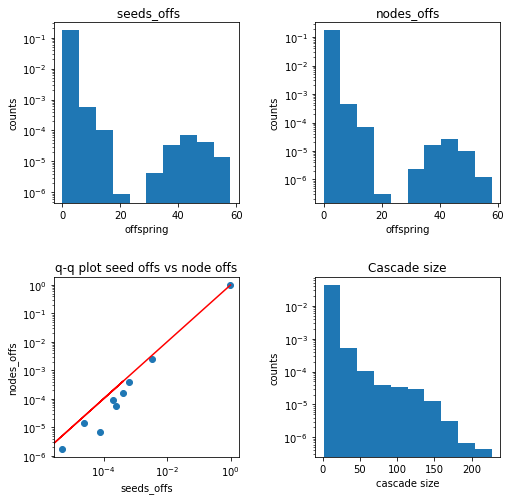

In [124]:
compute_independent_cascade(graph, prob=0.5)
#prob ct que multiplica la diferencia de opinion en la probabilidad de succeed information cascade
#max([graph.out_degree(i) for i in range(0,len(graph.out_degree()))])

# SACAR 4 PRIMEROS OFFS DE LOS NODOS

In [125]:
def compute_independent_cascade(graph, prob, n_iters=200000):
    total_spead = 0
    seeds_offs=[]
    nodes_offs=[]
    cascade_size=[]
    primer_off=[]
    sec_off=[]
    ter_off=[]
    cuar_off=[]
    # simulate the spread process over multiple runs
    for i in range(n_iters):
        seed_nodes = [np.random.choice(graph.nodes)]

        np.random.seed(i)
        active = seed_nodes[:]
        new_active = seed_nodes[:]
        
        # for each newly activated nodes, find its neighbors that becomes activated
        
        num=0#contador para separar las seeds offspring y node offspring
        while new_active:
            
            num=num+1
            
            activated_nodes = []
            
            for node in new_active:
                neighbors = list(graph.neighbors(node))
                success = np.random.uniform(0, 1, len(neighbors)) < prob*(1-abs(opinion[node]-opinion[seed_nodes[0]]))
                activated_nodes += list(np.extract(success, neighbors))
                if node in seed_nodes:
                    seeds_offs.append(len(list(np.extract(success,neighbors))))
                else:
                    nodes_offs.append(len(list(np.extract(success,neighbors))))
            
            
                if num==1:
                    primer_off.append(len(list(np.extract(success,neighbors))))
                if num==2:
                    sec_off.append(len(list(np.extract(success,neighbors))))
                if num==3:
                    ter_off.append(len(list(np.extract(success,neighbors))))
                if num==4:
                    cuar_off.append(len(list(np.extract(success,neighbors))))
            
            
            
            
            
            
            new_active = list(set(activated_nodes) - set(active))
            active += new_active

        total_spead += len(active)
        #print(total_spead)
               
        cascade_size.append(len(active))
    fig = plt.figure("seed offspring and node offspring", figsize=(8, 8))
    # Create a gridspec for adding subplots of different sizes
    axgrid = fig.add_gridspec(11, 11)


    #n_bins1=len(seeds_offs)
    counts, bins = np.histogram(seeds_offs)
    #plt.hist(bins[:-1], bins, weights=counts)
    #print(n_bins1)
    ax0 = fig.add_subplot(axgrid[:3, :3])
    ax0.hist(bins[:-1], bins, weights=counts,density=True )
    ax0.set_title(" seeds_offs")
    #ax1.set_xscale('log')
    ax0.set_yscale('log')
    ax0.set_ylabel("counts")
    ax0.set_xlabel("offspring")


    #n_bins2=len(nodes_offs)
    counts1, bins1 = np.histogram(nodes_offs)
    #plt.hist(bins[:-1], bins, weights=counts)

    ax1 = fig.add_subplot(axgrid[:3, 4:7])
    ax1.hist(bins[:-1], bins, weights=counts1,density=True)
    ax1.set_title("nodes_offs")
    #ax3.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_ylabel("counts")
    ax1.set_xlabel("offspring")
    #print(n_bins2)

    
    counts2, bins2 = np.histogram(primer_off)
    ax2 = fig.add_subplot(axgrid[4:7, :3])
    ax2.hist(bins2[:-1], bins2, weights=counts2 ,density=True)
    ax2.set_title("primer off")
    #ax3.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_ylabel("counts")
    ax2.set_xlabel("offspring primer nodo tras seed")
    #print(n_bins2)
    
    
      
    counts3, bins3 = np.histogram(sec_off) 
    ax3 = fig.add_subplot(axgrid[4:7, 4:7])
    #ax3.hist(bins2[:-1], bins2, weights=counts1,density=True)
    #ax3.scatter(np.log(counts),np.log(counts1))
    #ax3.plot(np.log(counts),np.log(counts),color='red')
    ax3.hist(bins3[:-1], bins3, weights=counts3 ,density=True)
    #ax3.plot((counts)/sum(counts),(counts)/sum(counts),color='red')
    ax3.set_title("second node after seed offs")
    #ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.set_ylabel("prob")
    ax3.set_xlabel("sec_offs")
    #print(n_bins2)
    
     #n_bins2=len(nodes_offs)
    counts4, bins4 = np.histogram(ter_off)
    #plt.hist(bins[:-1], bins, weights=counts)

    ax4 = fig.add_subplot(axgrid[4:7, 8:11])

    ax4.hist(bins4[:-1], bins4, weights=counts4,density=True)
    ax4.set_title("ter_offs")
    #ax3.set_xscale('log')
    ax4.set_yscale('log')
    ax4.set_ylabel("prob")
    ax4.set_xlabel("offspring")
    #print(n_bins2)

    
     #n_bins2=len(nodes_offs)
    counts5, bins5 = np.histogram(cuar_off)
    #plt.hist(bins[:-1], bins, weights=counts)

    ax5 = fig.add_subplot(axgrid[8:11, :3])
    ax5.hist(bins5[:-1], bins5, weights=counts5,density=True)
    ax5.set_title("cuar_offs")
    #ax3.set_xscale('log')
    ax5.set_yscale('log')
    ax5.set_ylabel("prob")
    ax5.set_xlabel("offspring")
    #print(n_bins2)

        
        
        
    print('el numero maximo de offspring del seed es   ', max(seeds_offs)) 
    print('el numero maximo de offspring de los nodos es   ', max(nodes_offs)) 
    print('el numero maximo de vecinos out en la red es   ', max([graph.out_degree(i) for i in range(0,len(graph.out_degree()))]))    

    return total_spead / n_iters, fig


"""# assuming we start with 1 seed node

seed_nodes = [np.random.choice(graph.nodes)]
                        
compute_independent_cascade(graph, seed_nodes, prob=0.5)"""

'# assuming we start with 1 seed node\n\nseed_nodes = [np.random.choice(graph.nodes)]\n                        \ncompute_independent_cascade(graph, seed_nodes, prob=0.5)'

el numero maximo de offspring del seed es    58
el numero maximo de offspring de los nodos es    59
el numero maximo de vecinos out en la red es    88


(3.87767, <Figure size 576x576 with 6 Axes>)

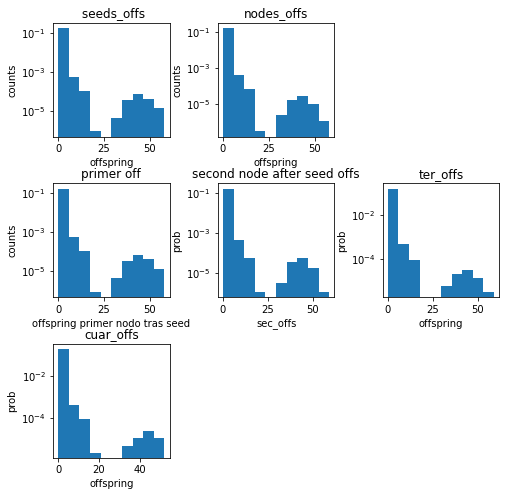

In [126]:
compute_independent_cascade(graph, prob=0.5)
